# Präsenzversuch zum Laval-Rotor

Name:  David Büning
Datum:  6.02.2024
Gruppe: 13

## Forschungsfrage

Wie lassen sich Schwingungsmerkmale des Lavalrotors am Campbell Diagramm ablesen? Wie unterscheiden sich die Merkmale der drei Prüfstände?

## Erster Versuch: Prüfstand 04
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="lavalrotor_laboratory.jpg" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:
Im Versuch wurde ein klassischer Lavalrotor aufgebaut. In der Mitte befindet sich eine einzige Scheibe mit dem Gewicht von 1000g. Auf der rechten Seite wird die Welle durch einen Motor angetrieben. Außerdem wird die Welle jeweils außen durch Pendelrollenlager gelagert.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240117_154512_lavalrotor_13_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240117_154512_lavalrotor_13_04.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240117_154512_lavalrotor_13_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240117_154512_lavalrotor_13_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240117_154512_lavalrotor_13_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240117_154512_lavalrotor_13_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [5]:
# leere Listen erstellen
time = []
a_abs = []
rpm = []
amplitude = []
frequenz = []

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [6]:
importlib.reload(m_postprocessing)  # reload functions

# Pfad erstellen
path = path_measurement_folder + "/" + filename

with h5py.File(path) as f:
    for i in f.keys():
        group = f[i]["RawData"]
        
        # Auslesen der Beschleunigungen und Zeitschritte
        acc_x_i = np.array(group[uuid_acceleration]["acceleration_x"])
        acc_y_i = np.array(group[uuid_acceleration]["acceleration_y"])
        acc_z_i = np.array(group[uuid_acceleration]["acceleration_z"])
        time_i = np.array(group[uuid_acceleration]["timestamp"])
        time.append(time_i)
        
        # Auslesen der Umdrehungen und Liste hinzufügen
        rpm_i = group[uuid_motor_rpm]["motor_rpm"][()]
        rpm.append(rpm_i)
        
        # Absolutbeschleunigung berechnen
        a_abs_i = m_postprocessing.get_vec_accel(acc_x_i, acc_y_i, acc_z_i)
        
        # Interpolation der Absolutbeschleunigung mit den Interpolation Points
        a_int_i = m_postprocessing.interpolation(time_i, a_abs_i, interpolation_points)
        
        # Amplitude und Frequenz berechnen mit fft 
        amplitude_i, frequenz_i = m_postprocessing.my_fft_scaled(a_int_i, interpolation_points)
        amplitude.append(amplitude_i)
        frequenz.append(frequenz_i)
         
   

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

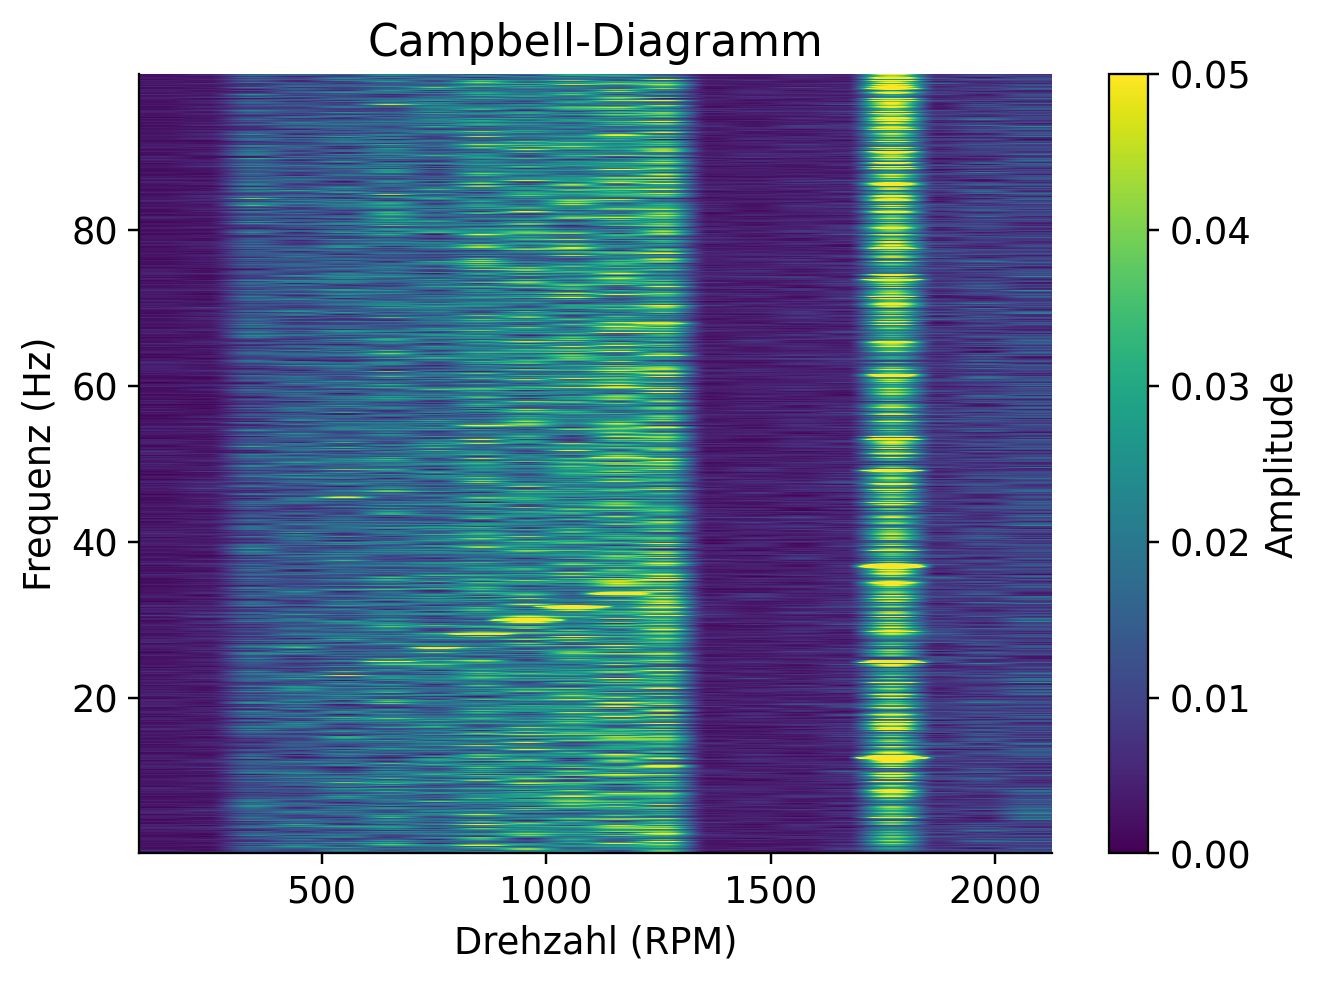

In [7]:
# Diagramm mit imshow Befehl erstellen, x Achse als Frequenz und y Achse als Drehzahl
plt.imshow(np.transpose(amplitude), extent=[np.min(rpm), np.max(rpm), np.min(frequenz), np.max(frequenz)],
           aspect='auto', cmap='viridis', origin='lower', vmin = 0, vmax = 0.05)
# Farbskala für Amplituden
plt.colorbar(label='Amplitude')  
# Achsen labeln
plt.ylabel('Frequenz (Hz)')
plt.xlabel('Drehzahl (RPM)')
# Titel und Plotten
plt.title('Campbell-Diagramm')
plt.show()

## Zweiter Datensatz: Prüfstand 02

#### 1. Einlesen der Mess- und Metadaten

In [8]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [9]:
# leere Listen erstellen
time = []
a_abs = []
rpm = []
amplitude = []
frequenz = []

importlib.reload(m_postprocessing)  # reload functions

# Pfad erstellen
path = path_measurement_folder + "/" + filename

with h5py.File(path) as f:
    for i in f.keys():
        group = f[i]["RawData"]
        
        # Auslesen der Beschleunigungen und Zeitschritte
        acc_x_i = np.array(group[uuid_acceleration]["acceleration_x"])
        acc_y_i = np.array(group[uuid_acceleration]["acceleration_y"])
        acc_z_i = np.array(group[uuid_acceleration]["acceleration_z"])
        time_i = np.array(group[uuid_acceleration]["timestamp"])
        time.append(time_i)
        
        # Auslesen der Umdrehungen und Liste hinzufügen
        rpm_i = group[uuid_motor_rpm]["motor_rpm"][()]
        rpm.append(rpm_i)
        
        # Absolutbeschleunigung berechnen
        a_abs_i = m_postprocessing.get_vec_accel(acc_x_i, acc_y_i, acc_z_i)
        
        # Interpolation der Absolutbeschleunigung mit den Interpolation Points
        a_int_i = m_postprocessing.interpolation(time_i, a_abs_i, interpolation_points)
        
        # Amplitude und Frequenz berechnen mit fft 
        amplitude_i, frequenz_i = m_postprocessing.my_fft_scaled(a_int_i, interpolation_points)
        amplitude.append(amplitude_i)
        frequenz.append(frequenz_i)
        

#### 3. Darstellung mittels Campbell-Diagramm

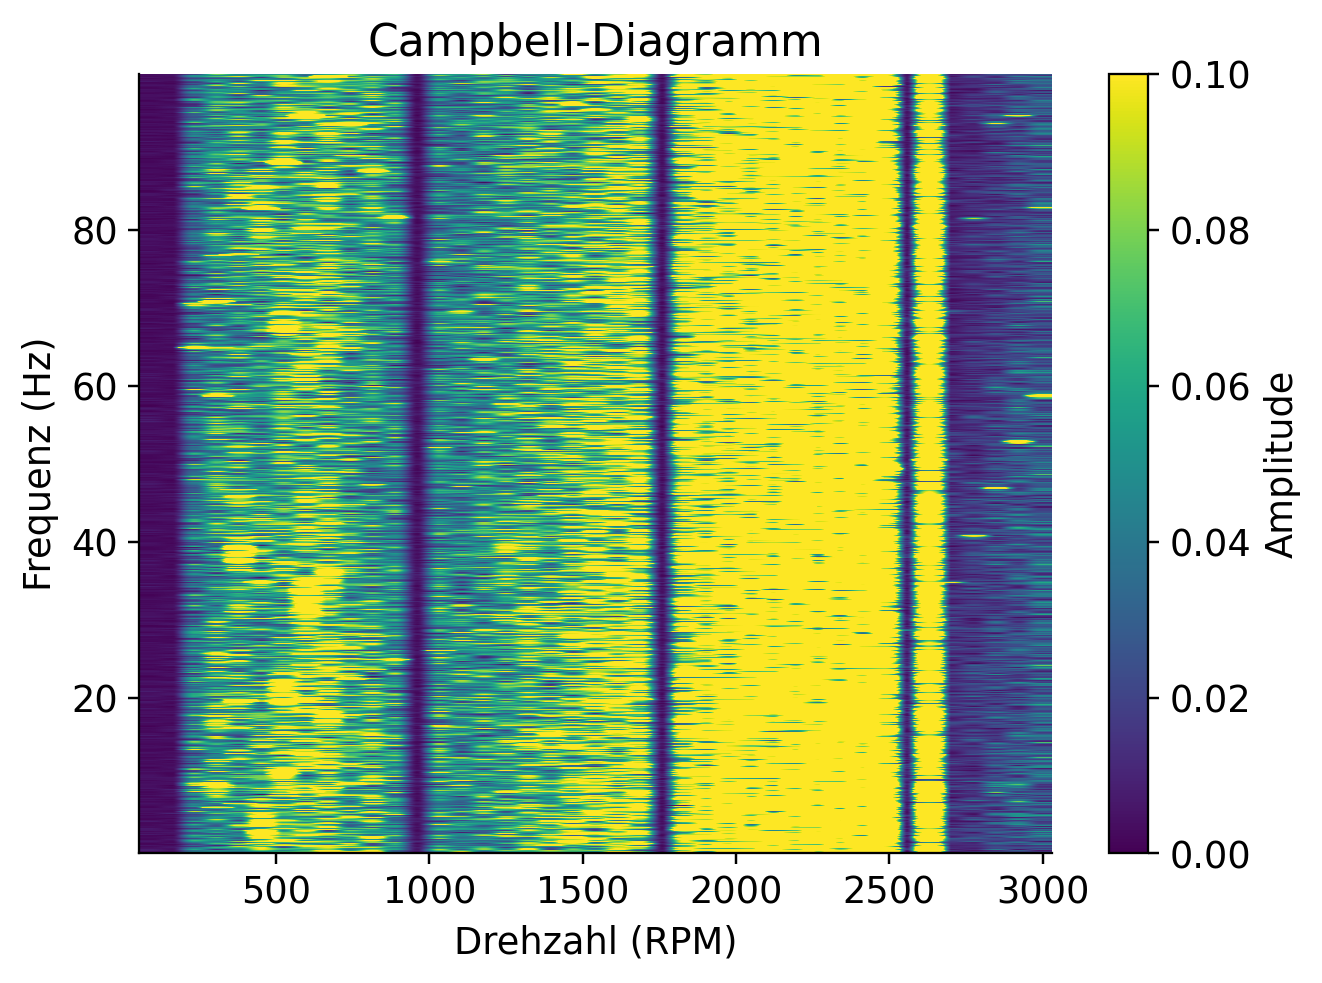

In [10]:
# Diagramm mit imshow Befehl erstellen, x Achse als Frequenz und y Achse als Drehzahl
plt.imshow(np.transpose(amplitude), extent=[np.min(rpm), np.max(rpm), np.min(frequenz), np.max(frequenz)],
           aspect='auto', cmap='viridis', origin='lower', vmin = 0, vmax = 0.1)
# Farbskala für Amplituden
plt.colorbar(label='Amplitude')  
# Achsen labeln
plt.ylabel('Frequenz (Hz)')
plt.xlabel('Drehzahl (RPM)')
# Titel und Plotten
plt.title('Campbell-Diagramm')
plt.show()

## Dritter Datensatz: Prüfstand 03

#### 1. Einlesen der Mess- und Metadaten

In [11]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [12]:
# leere Listen erstellen
time = []
a_abs = []
rpm = []
amplitude = []
frequenz = []

importlib.reload(m_postprocessing)  # reload functions

# Pfad erstellen
path = path_measurement_folder + "/" + filename

with h5py.File(path) as f:
    for i in f.keys():
        group = f[i]["RawData"]
        
        # Auslesen der Beschleunigungen und Zeitschritte
        acc_x_i = np.array(group[uuid_acceleration]["acceleration_x"])
        acc_y_i = np.array(group[uuid_acceleration]["acceleration_y"])
        acc_z_i = np.array(group[uuid_acceleration]["acceleration_z"])
        time_i = np.array(group[uuid_acceleration]["timestamp"])
        time.append(time_i)
        
        # Auslesen der Umdrehungen und Liste hinzufügen
        rpm_i = group[uuid_motor_rpm]["motor_rpm"][()]
        rpm.append(rpm_i)
        
        # Absolutbeschleunigung berechnen
        a_abs_i = m_postprocessing.get_vec_accel(acc_x_i, acc_y_i, acc_z_i)
        
        # Interpolation der Absolutbeschleunigung mit den Interpolation Points
        a_int_i = m_postprocessing.interpolation(time_i, a_abs_i, interpolation_points)
        
        # Amplitude und Frequenz berechnen mit fft 
        amplitude_i, frequenz_i = m_postprocessing.my_fft_scaled(a_int_i, interpolation_points)
        amplitude.append(amplitude_i)
        frequenz.append(frequenz_i)
      

#### 3. Darstellung mittels Campbell-Diagramm

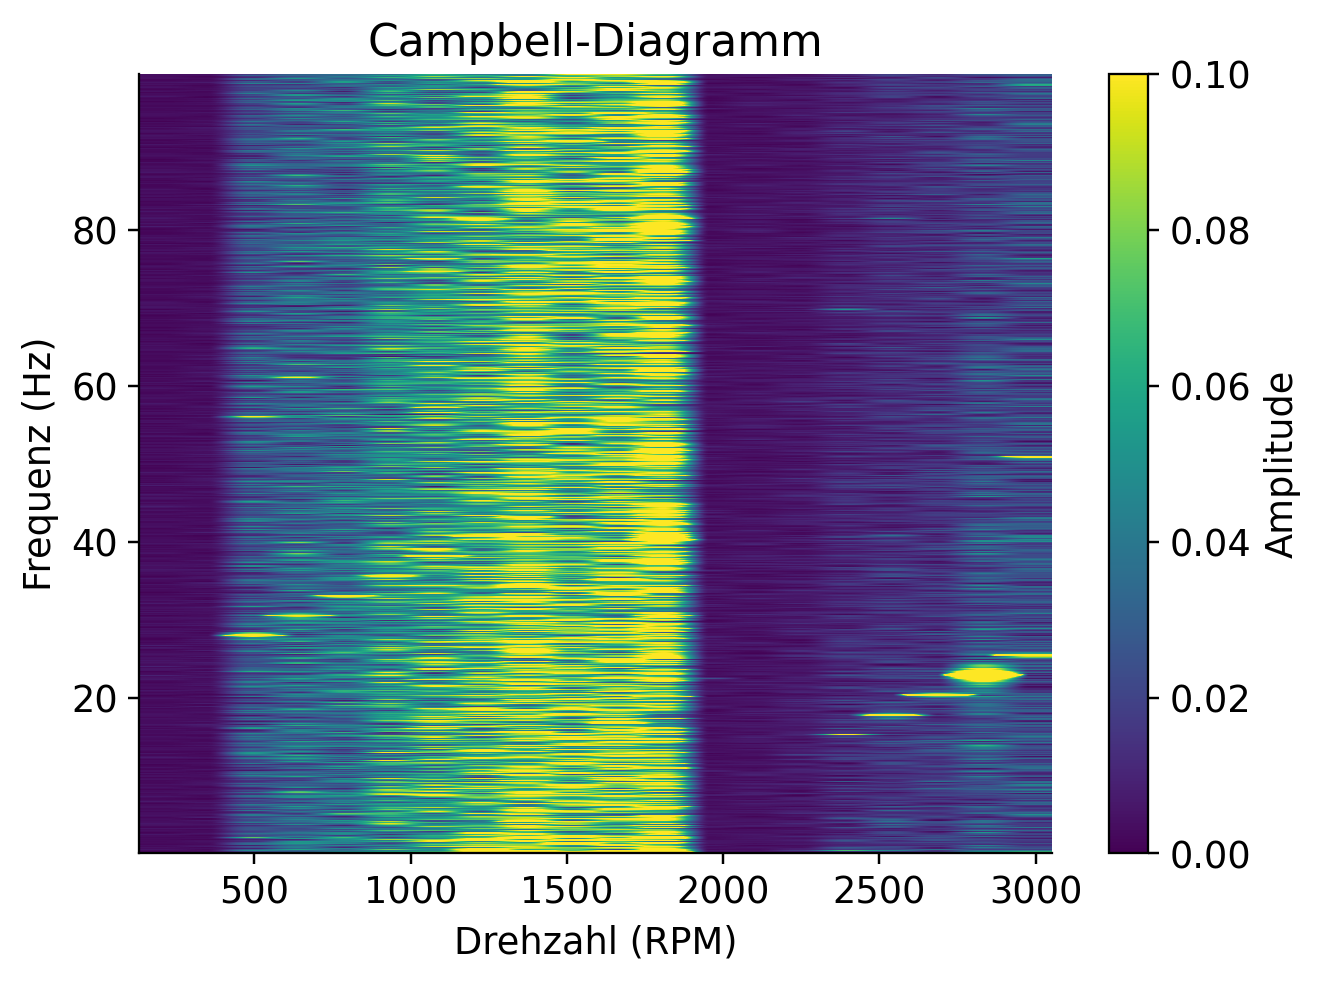

In [13]:
# Diagramm mit imshow Befehl erstellen, x Achse als Frequenz und y Achse als Drehzahl
plt.imshow(np.transpose(amplitude), extent=[np.min(rpm), np.max(rpm), np.min(frequenz), np.max(frequenz)],
           aspect='auto', cmap='viridis', origin='lower', vmin = 0, vmax = 0.1)
# Farbskala für Amplituden
plt.colorbar(label='Amplitude')  
# Achsen labeln
plt.ylabel('Frequenz (Hz)')
plt.xlabel('Drehzahl (RPM)')
# Titel und Plotten
plt.title('Campbell-Diagramm')
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

In den Diagrammen sind helle und dunkle Bereiche zu unterscheiden. Die hellen Bereiche weisen eine hohe Amplitude auf und deuten auf hohe Schwingungen hin. 
##### Prüfstand 02:
Stabiler Bereich: 900 - 1000 rpm, 1700 - 1800 rpm, 2600 - 3000 rpm

Instabiler Bereich: 200 - 900 rpm, 1000 - 1700 rpm, 1800 - 2600 rpm

##### Prüfstand 03:
Stabiler Bereich: 1900 - 3000 rpm

Instabiler Bereich: 400 - 1900 rpm 

##### Prüfstand 04:
Stabiler Bereich: 0 - 250 rpm, 1400 - 1700 rpm, 1800 - 2200 rpm

Instabiler Bereich: 250 - 1400 rpm, 1700 - 1800 rpm

Demnach kann man sagen, dass Prüfstand 2 und 4 mehrere Drehzahlen haben, bei denen die Schwingungen groß und auch wieder klein sind. Bei Prüfstand 3 kann man dies besser differenzieren: Ist die Drehzahl größer als 1900 rpm, muss nicht mehr mit einem kritischen Bereich/ hohen Amplituden gerechnet werden. 

Die Selbstzentrierung ist sehr deutlich bei Prüfstand 2 zu sehen. Bei den Drehzahlen 900, 1700 und 2600 gibt es kleine Bereiche in denen das System kaum schwingt. 

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Beim Experiment haben wie die kritische Drehzahl zu 450 rpm berechnet (Prüfstand 4). Diese befindet sich auch im Campbell Diagramm im instabilen Bereich, ist jedoch nicht die Drehzahl mit den höchsten Amplituden. Diese liegt schätzungsweise bei 1750 rpm. Die Abweichungen sind auf Vereinfachungen/ Annahmen bei der Rechnung und Messfehler bei den Sensoren zurück zu führen.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.


Das Experiment, bei dem ich ein Campbell-Diagramm basierend auf Daten eines Lavalrotors erstellt habe, war eine lehrreiche Erfahrung. Es hat mir nicht nur Spaß gemacht, sondern auch meine Fähigkeiten im Datenmanagement ein letztes mal optimiert.

Die Visualisierung der Daten ermöglichte mir einen Einblick in die Rotordynamik und half mir, die Beziehung zwischen Drehzahl, Eigenfrequenzen und Amplituden zu verstehen. Die Anwendung von Python und Matplotlib erleichterte die Analyse und trug zum besseren Verständnis der Ergebnisse bei.

Insgesamt war das Experiment eine lohnende Erfahrung, die mein Wissen erweitert hat und mich dazu motiviert hat, weiter in diesem Bereich zu forschen.